In [2]:
import math
from dataclasses import dataclass

import numpy as np
import IPython
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

import torch
import torchaudio
import torchaudio.functional as F

torch.random.manual_seed(0)
print(torch.__version__)
print(torchaudio.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from lync.aligner import *

1.12.1+cu116
0.12.1+cu113
cuda


In [3]:
w2v2_bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
w2v2_model = w2v2_bundle.get_model().to(device)
labels = w2v2_bundle.get_labels()

CHUNKS = 6
waveform, srate = torchaudio.load("./cli-test/Nicki Minaj - Anaconda/vocals.wav")
print("srate", srate)
w_len = waveform.shape[1]
chunk_len = int(math.ceil(w_len/CHUNKS))
waveforms = [waveform[0, i:min(w_len,i+chunk_len)].unsqueeze(0) for i in range(CHUNKS)]

srate 44100


In [3]:
emissions_list = []
with torch.inference_mode():
    for i in range(CHUNKS):
        emission, _ = w2v2_model(waveforms[i].to(device))
        emissions_list.append(torch.log_softmax(emission, dim=-1))
emissions = torch.cat(emissions_list, 0)
emission = emissions[0, :].cpu().detach()

In [4]:
print(emission.shape)

torch.Size([5995, 29])


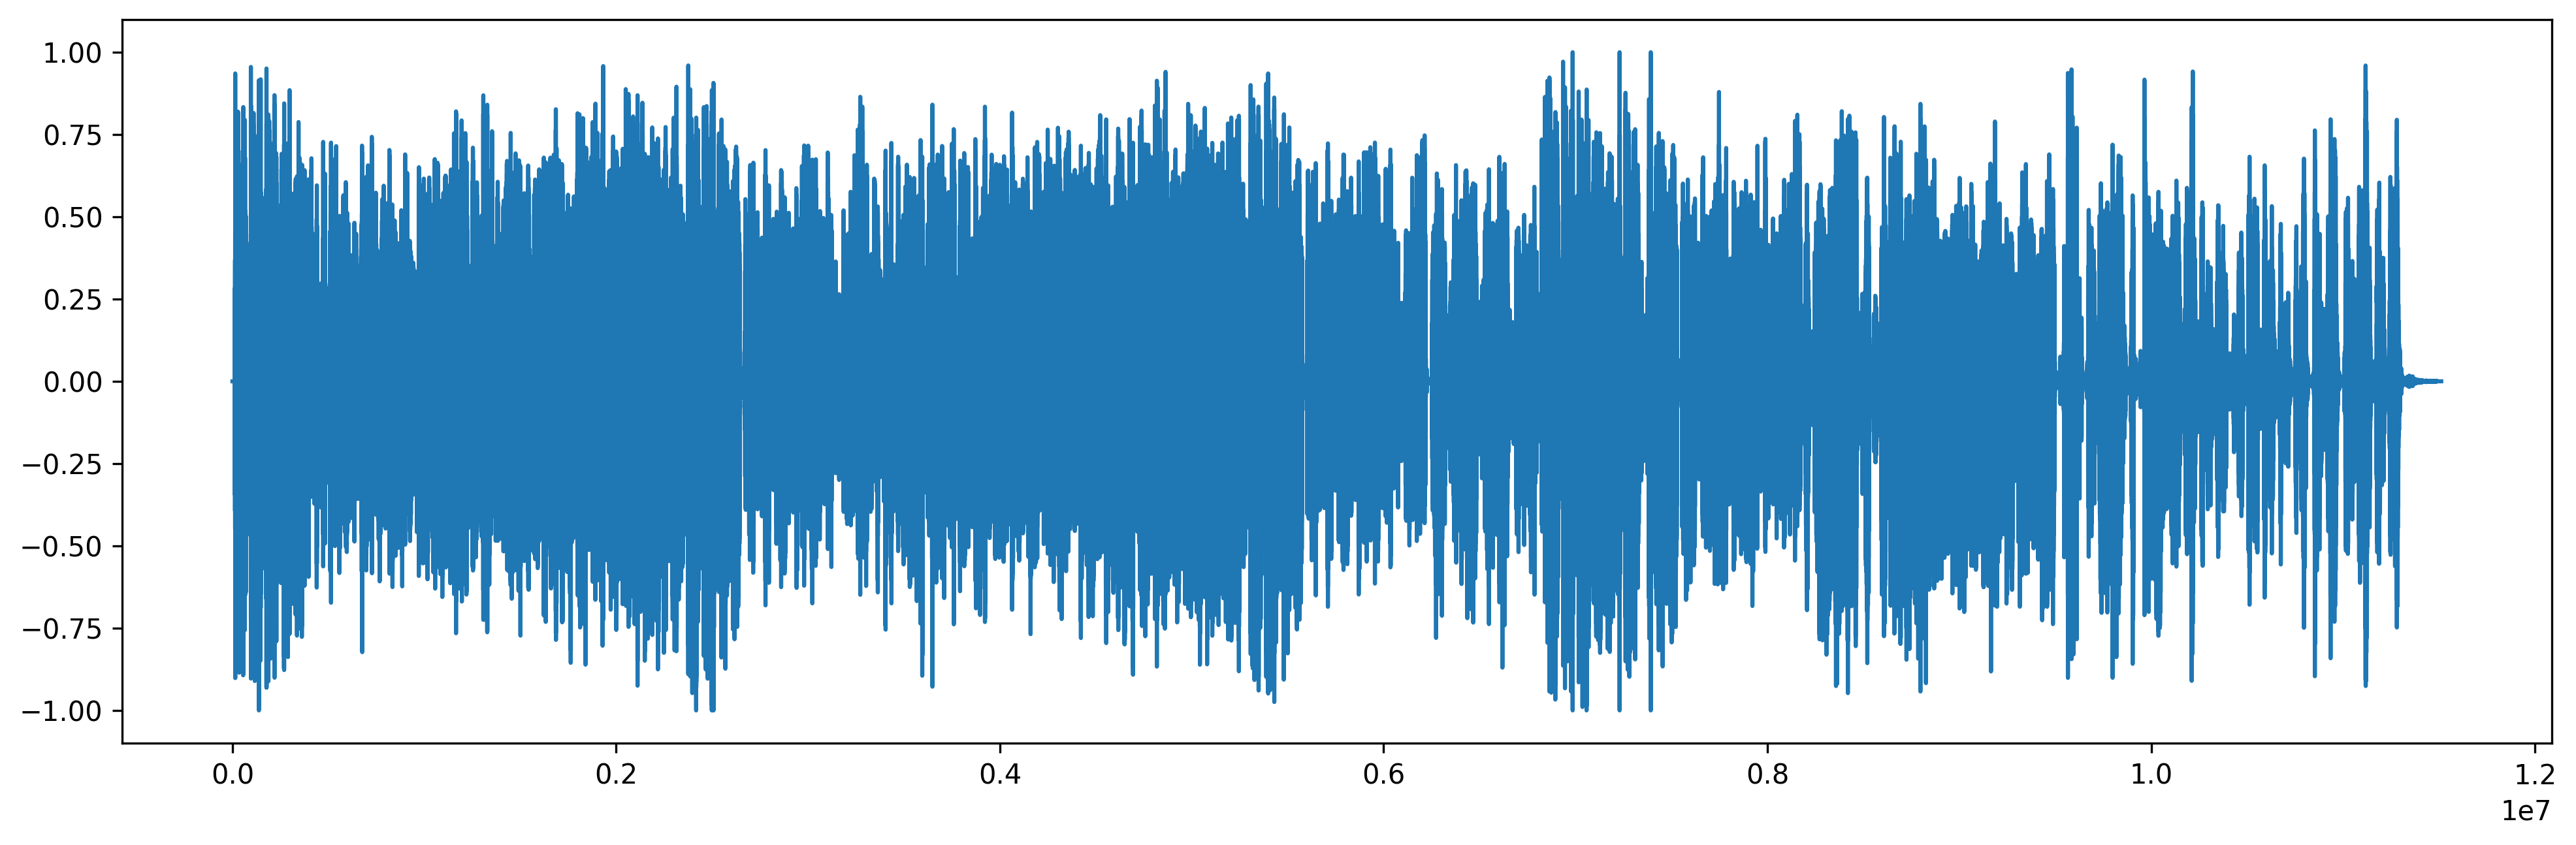

In [8]:
matplotlib.rcParams["figure.dpi"] = 300
matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]
plt.plot(waveform[:srate*3].numpy()[0])
plt.show()

In [11]:
resample_rate = 32000 # vad only works for integer mults of 16khz
waveform_downsampled =  F.resample(
    waveform,
    srate,
    resample_rate,
    lowpass_filter_width=64,
    rolloff=0.9475937167399596,
    resampling_method="kaiser_window",
    beta=14.769656459379492,
)
print(waveform_downsampled.shape)

torch.Size([2, 8353367])


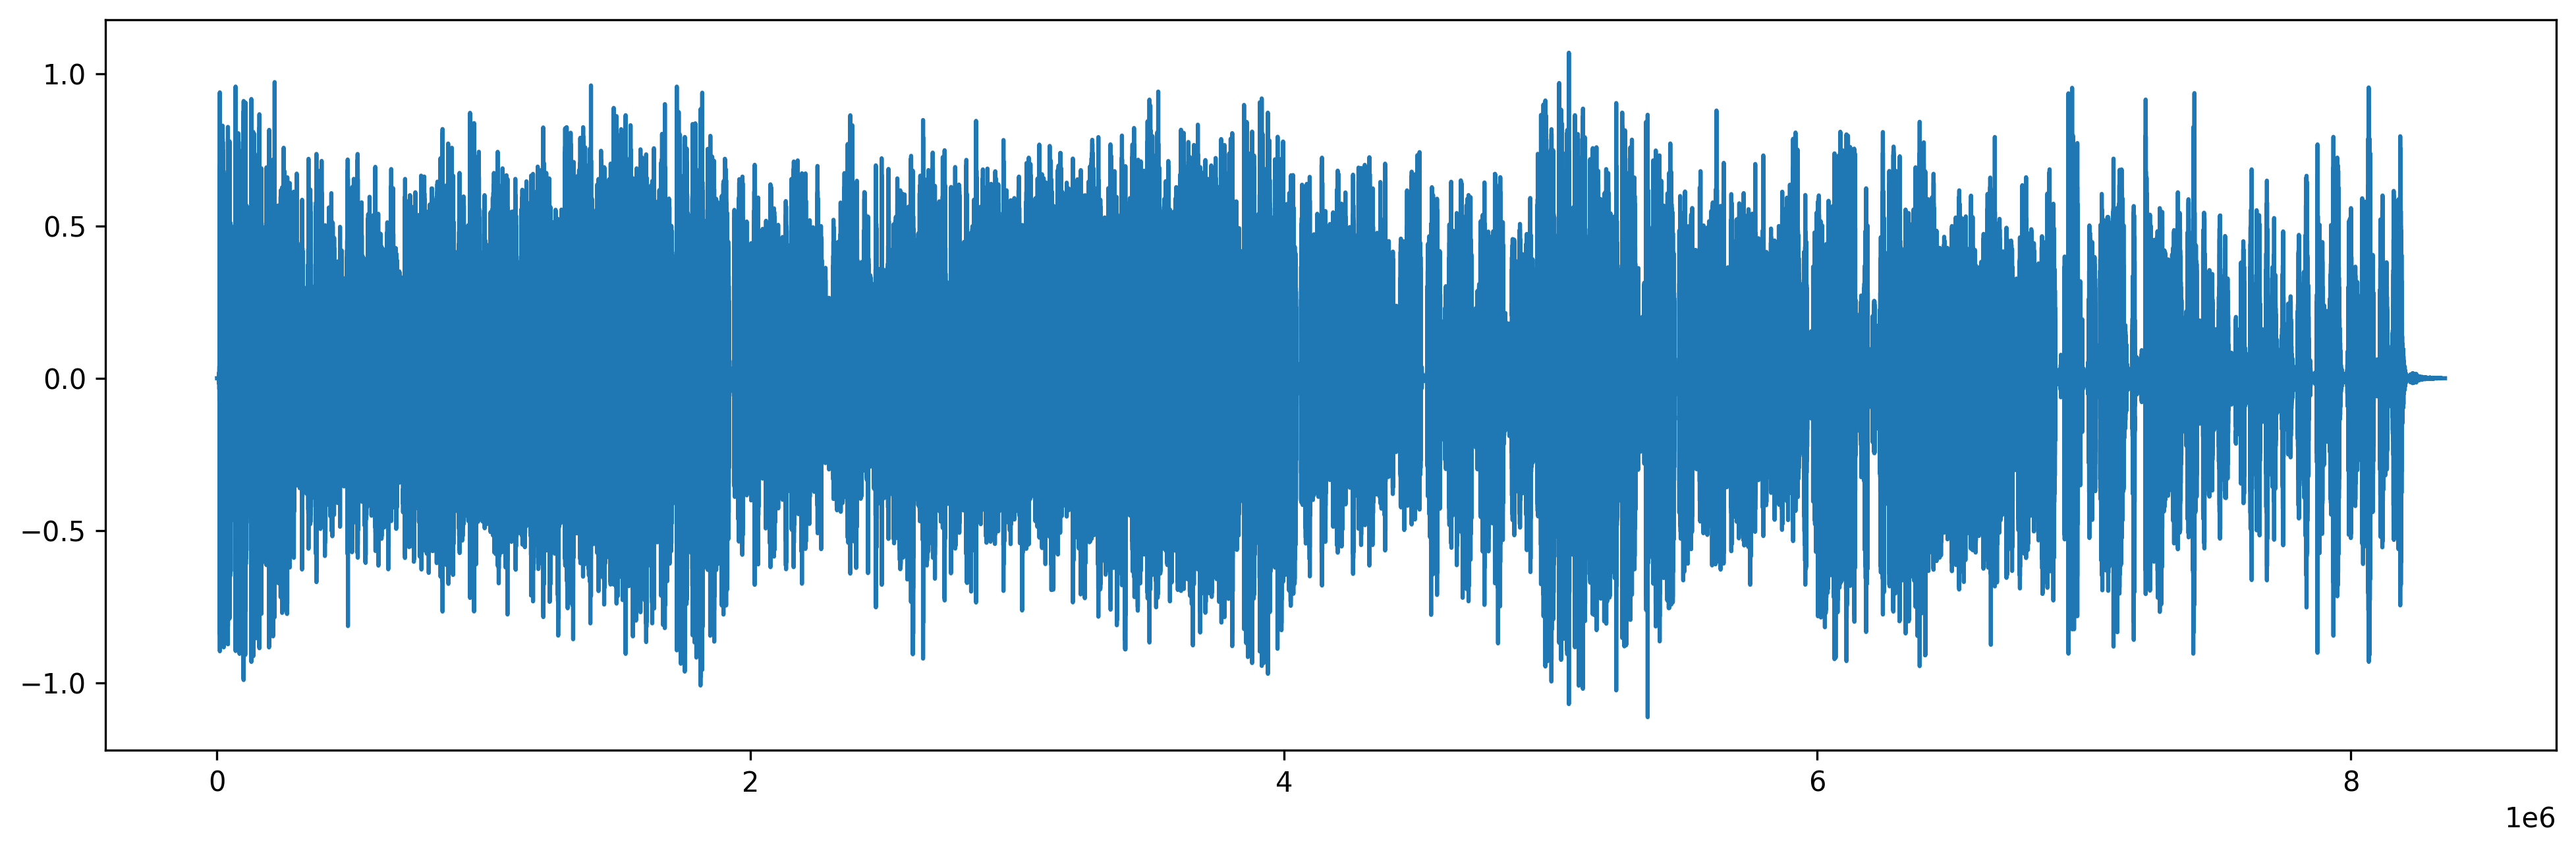

In [18]:
plt.plot(waveform_downsampled[:resample_rate*3].numpy()[0])
plt.show()

In [23]:
#num_audio_frames = 1000#emission.shape[0]
audio_frame_len = int(resample_rate*0.03) # 30ms #int(math.ceil(w_len / num_audio_frames))
num_audio_frames = int(math.floor(waveform_downsampled.shape[1]/audio_frame_len))
print("num frames", num_audio_frames)
vad_frames = [waveform_downsampled[0, i*audio_frame_len:min(waveform_downsampled.shape[1],i*audio_frame_len+audio_frame_len)].unsqueeze(0) for i in range(num_audio_frames)]

num frames 8701


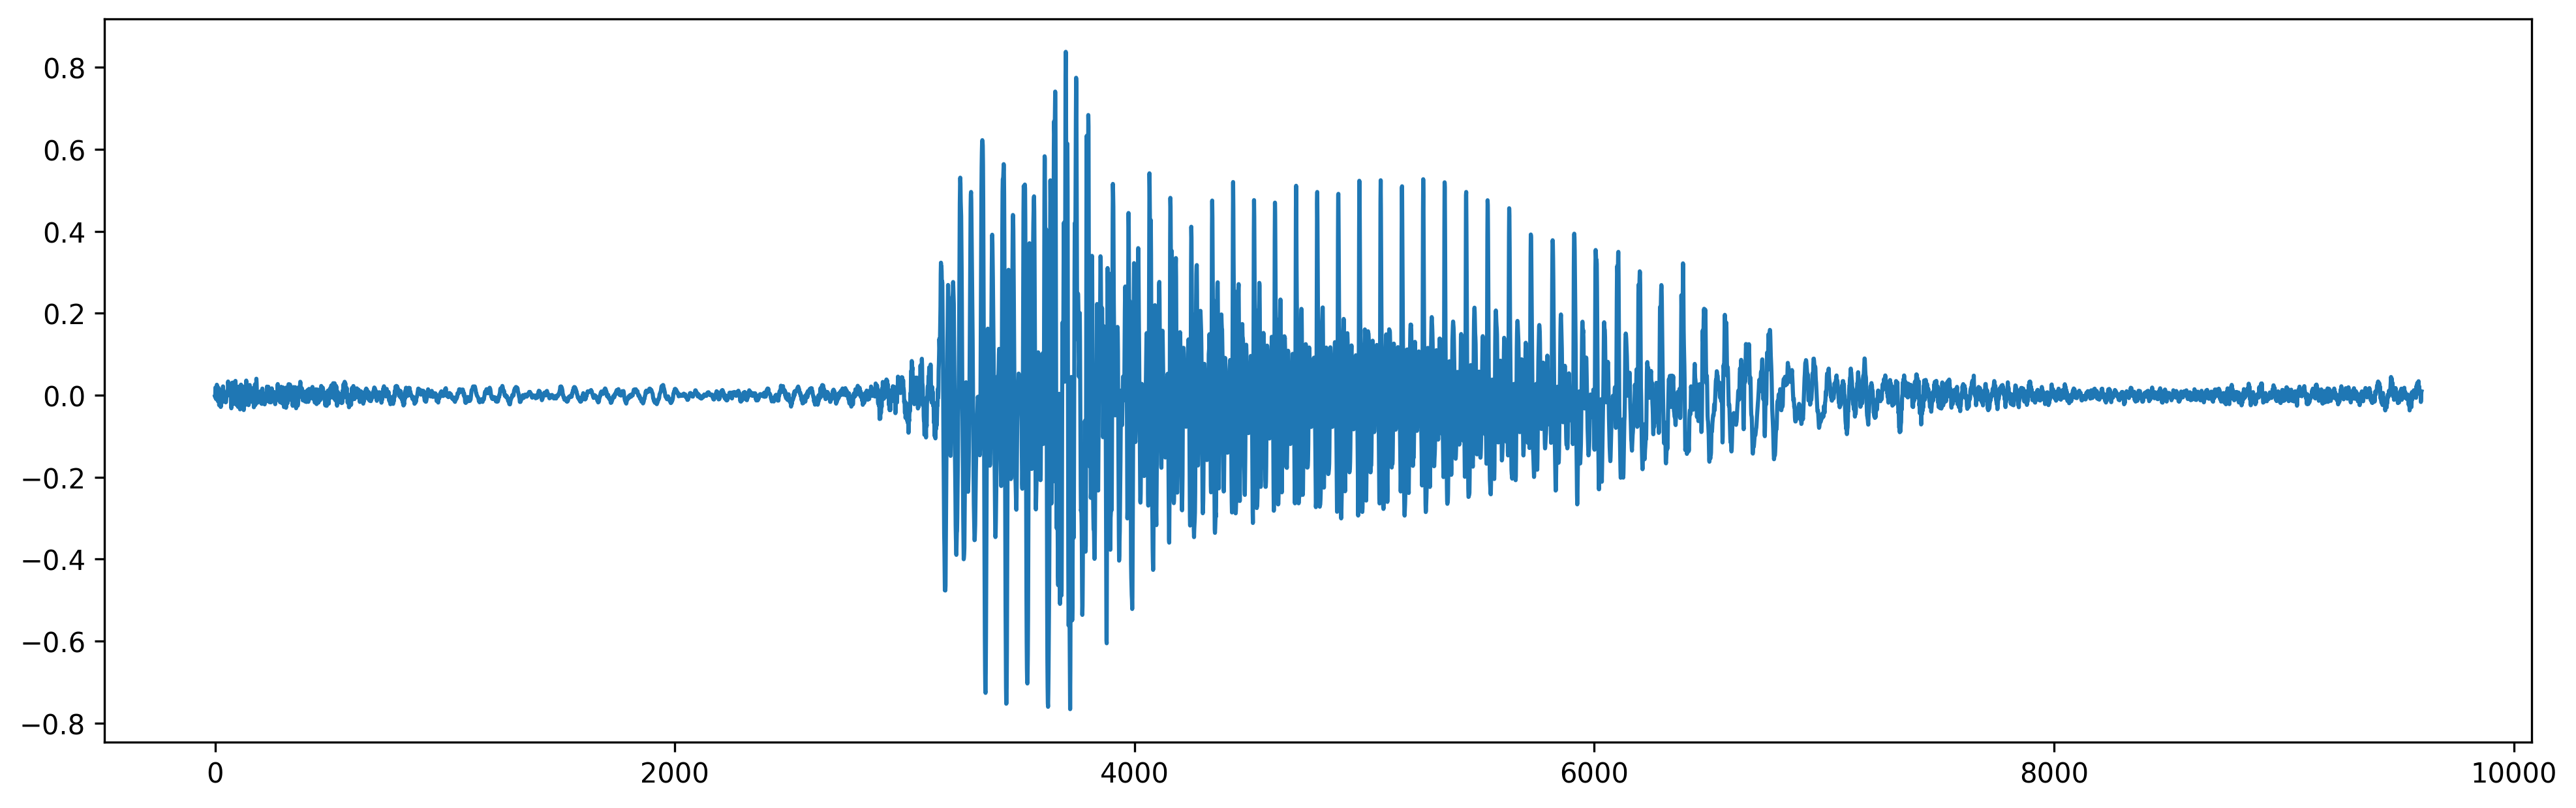

In [24]:
plt.plot(vad_frames[100].numpy()[0])
plt.show()

In [6]:
vad_model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True)

(get_speech_timestamps,
 save_audio,
 read_audio,
 VADIterator,
 collect_chunks) = utils
 

Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to C:\Users\TheoA/.cache\torch\hub\master.zip


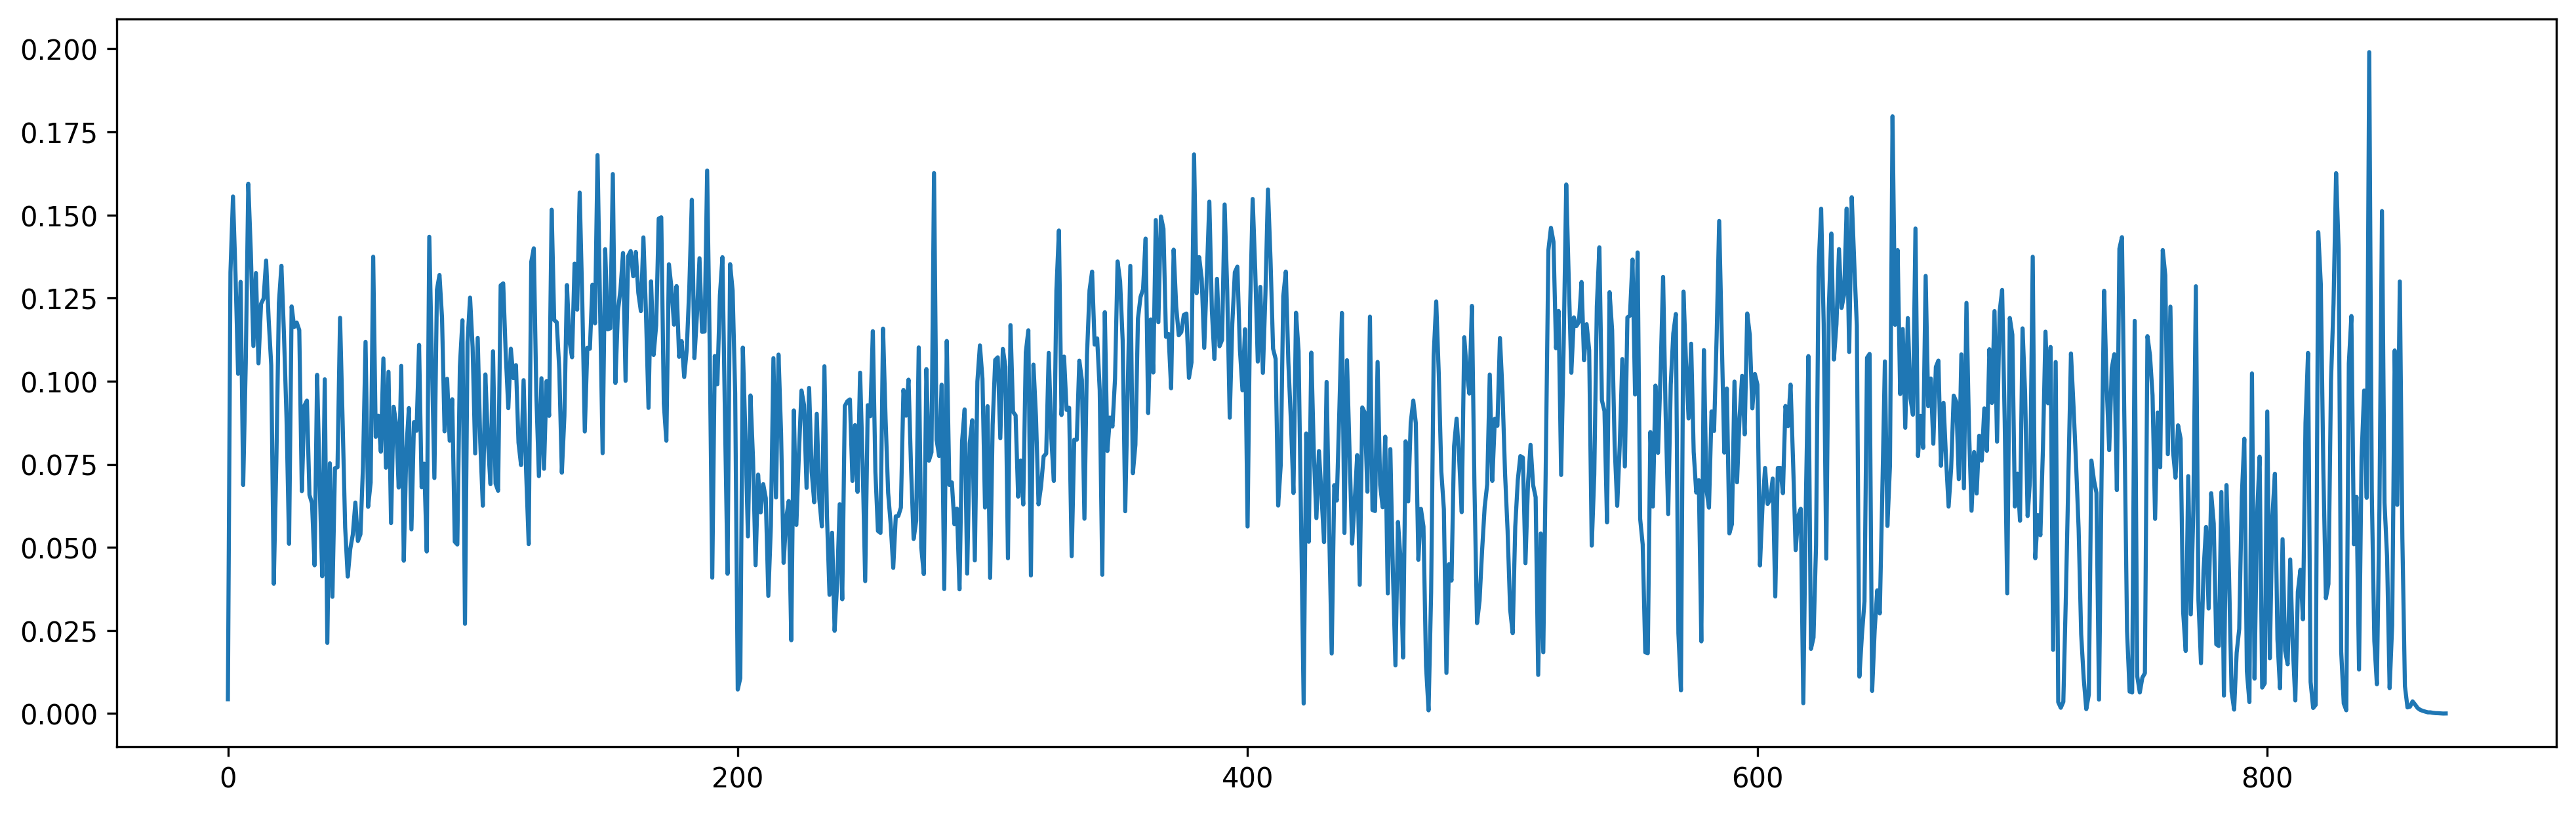

In [25]:
plt.plot([torch.mean(torch.abs(frame)) for frame in vad_frames])

In [19]:
print(waveform_downsampled.shape[1]/num_audio_frames)

6966.94495412844


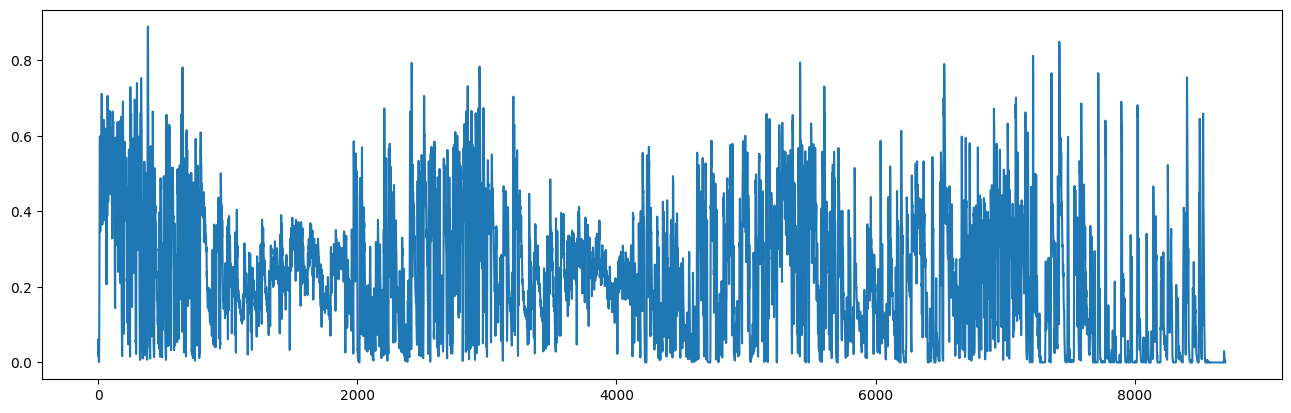

In [24]:
vad_confidences = []
for frame_idx, frame in enumerate(vad_frames):
    vad_confidences.append(vad_model(frame, resample_rate).item())
plt.plot(vad_confidences)
plt.show()